# Подход к решению
Возможные подходы:
1. Разбить слова на слоги по правилам русского языка.  Слово будет "текстом", слоги будут играть роль "слов". Дальше используем стандартные средства работы с текстом (векторизация и эмбеддинг слогов и т.п.).
2. Разбить слова на буквы, делать векторизацию букв. Алгоритм сам будет выявлять закономерности

В этой версии использую второй подход.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import chime

In [2]:
%load_ext chime

In [3]:
df = pd.read_csv('train.csv', index_col='id'); df

,word,stress,num_syllables,lemma
id,,,,
0,румяной,2,3,румяный
1,цифрами,1,3,цифра
2,слугами,1,3,слуга
3,выбирает,3,4,выбирать
4,управдом,3,3,управдом
...,...,...,...,...
63433,экзамена,2,4,экзамен
63434,культурой,2,3,культура
63435,объемной,2,3,объемный


Для удобства сдвигаю нумерацию слогов, чтобы она начиналась с 0. Не забыть сдвинуть обратно окончательный прогноз!

In [4]:
df.stress = df.stress - 1

# Набор символов
Нахожу все используемые символы

In [5]:
def add_char(word):
    global alphabeth
    alphabeth = alphabeth.union(set(list(word)))

In [6]:
alphabeth = set()

In [7]:
df.word.apply(add_char)

id
0        None
1        None
2        None
3        None
4        None
         ... 
63433    None
63434    None
63435    None
63436    None
63437    None
Name: word, Length: 63438, dtype: object

In [8]:
df.lemma.apply(add_char)

id
0        None
1        None
2        None
3        None
4        None
         ... 
63433    None
63434    None
63435    None
63436    None
63437    None
Name: lemma, Length: 63438, dtype: object

In [9]:
alphabeth

{'а',
 'б',
 'в',
 'г',
 'д',
 'е',
 'ж',
 'з',
 'и',
 'й',
 'к',
 'л',
 'м',
 'н',
 'о',
 'п',
 'р',
 'с',
 'т',
 'у',
 'ф',
 'х',
 'ц',
 'ч',
 'ш',
 'щ',
 'ъ',
 'ы',
 'ь',
 'э',
 'ю',
 'я',
 'ё'}

Нумерую буквы

In [10]:
numbers = list(range(1, len(alphabeth) + 1))

In [11]:
alphabeth = {k: v for k, v in zip(list(alphabeth), numbers)}; alphabeth

{'в': 1,
 'щ': 2,
 'ф': 3,
 'с': 4,
 'й': 5,
 'з': 6,
 'у': 7,
 'я': 8,
 'ш': 9,
 'л': 10,
 'м': 11,
 'к': 12,
 'р': 13,
 'ю': 14,
 'т': 15,
 'д': 16,
 'э': 17,
 'ж': 18,
 'х': 19,
 'и': 20,
 'п': 21,
 'ы': 22,
 'г': 23,
 'ь': 24,
 'ё': 25,
 'ц': 26,
 'ч': 27,
 'о': 28,
 'ъ': 29,
 'н': 30,
 'а': 31,
 'е': 32,
 'б': 33}

# Подготовка данных 

Число символов и слова отдельно, т.к. подаю на разные входы нейронной сети

In [12]:
y = df.stress
num_syllables = df.num_syllables
X = df.drop(columns=['stress', 'num_syllables'])

Разделяем на буквы

In [13]:
word = X.word.apply(lambda x: ' '.join(list(x)))
lemma = X.lemma.apply(lambda x: ' '.join(list(x)))

In [14]:
word = word.str.split(expand=True); word

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
id,,,,,,,,,,,,,,,,,,,,
0,р,у,м,я,н,о,й,None,None,None,None,None,None,None,None,None,None,None,None,None
1,ц,и,ф,р,а,м,и,None,None,None,None,None,None,None,None,None,None,None,None,None
2,с,л,у,г,а,м,и,None,None,None,None,None,None,None,None,None,None,None,None,None
3,в,ы,б,и,р,а,е,т,None,None,None,None,None,None,None,None,None,None,None,None
4,у,п,р,а,в,д,о,м,None,None,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63433,э,к,з,а,м,е,н,а,None,None,None,None,None,None,None,None,None,None,None,None
63434,к,у,л,ь,т,у,р,о,й,None,None,None,None,None,None,None,None,None,None,None
63435,о,б,ъ,е,м,н,о,й,None,None,None,None,None,None,None,None,None,None,None,None


In [15]:
lemma = lemma.str.split(expand=True); lemma

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
id,,,,,,,,,,,,,,,,,,,,
0,р,у,м,я,н,ы,й,None,None,None,None,None,None,None,None,None,None,None,None,None
1,ц,и,ф,р,а,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,с,л,у,г,а,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,в,ы,б,и,р,а,т,ь,None,None,None,None,None,None,None,None,None,None,None,None
4,у,п,р,а,в,д,о,м,None,None,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63433,э,к,з,а,м,е,н,None,None,None,None,None,None,None,None,None,None,None,None,None
63434,к,у,л,ь,т,у,р,а,None,None,None,None,None,None,None,None,None,None,None,None
63435,о,б,ъ,е,м,н,ы,й,None,None,None,None,None,None,None,None,None,None,None,None


Отсутсвующая буква в конце слова - 0. (Альтернативный вариант - ragged tensors.)

In [16]:
word.fillna(0, inplace=True)
lemma.fillna(0, inplace=True)

In [17]:
alphabeth[0] = 0

Заменяю буквы на номера

In [18]:
word = word.applymap(lambda x: alphabeth[x])
lemma = lemma.applymap(lambda x: alphabeth[x])

In [19]:
lemma

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
id,,,,,,,,,,,,,,,,,,,,
0,13,7,11,8,30,22,5,0,0,0,0,0,0,0,0,0,0,0,0,0
1,26,20,3,13,31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4,10,7,23,31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,22,33,20,13,31,15,24,0,0,0,0,0,0,0,0,0,0,0,0
4,7,21,13,31,1,16,28,11,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63433,17,12,6,31,11,32,30,0,0,0,0,0,0,0,0,0,0,0,0,0
63434,12,7,10,24,15,7,13,31,0,0,0,0,0,0,0,0,0,0,0,0
63435,28,33,29,32,11,30,22,5,0,0,0,0,0,0,0,0,0,0,0,0


Объединяю

In [20]:
X = np.concatenate((word, lemma), axis=1)

In [21]:
X_train, X_val, y_train, y_val, num_syllables_train, num_syllables_val = train_test_split(
    X,
    y,
    num_syllables,
    test_size=0.2, 
    random_state=42,
    shuffle=True
)

# Модель

In [22]:
embedding_dim = 6

In [23]:
word_input = keras.Input(
    shape=(40),
    name='words_and_lemmas'
)
syll_input = keras.Input(
    shape=(1),
    name='num_syllables'
)

w = layers.Embedding(
    input_dim=34,
    output_dim=embedding_dim,
    mask_zero=True,
    input_length=40)(word_input)
w = layers.LSTM(units=8,
               dropout=0.1)(w)

s = layers.Dense(1, activation='relu')(syll_input)

x = layers.concatenate([w, s])
x = layers.Dense(6, activation='relu')(x)
x = layers.Dropout(0.1)(x)

pred = layers.Dense(6, activation='softmax')(x)

model = keras.Model(
    inputs = [word_input, syll_input],
    outputs = [pred]
)

In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 words_and_lemmas (InputLayer)  [(None, 40)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 40, 6)        204         ['words_and_lemmas[0][0]']       
                                                                                                  
 num_syllables (InputLayer)     [(None, 1)]          0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 8)            480         ['embedding[0][0]']              
                                                                                              

In [25]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer='adam',
              metrics='accuracy')

In [38]:
%%time
%%chime
history=model.fit(
    {'words_and_lemmas': X_train,
    'num_syllables': num_syllables_train},
    y_train,
    epochs=500,
    verbose=1,
    validation_split=0.1
)

Epoch 1/500
1428/1428 [==============================] - 20s 14ms/step - loss: 0.6766 - accuracy: 0.7138 - val_loss: 0.6246 - val_accuracy: 0.7371
Epoch 2/500
1428/1428 [==============================] - 20s 14ms/step - loss: 0.6686 - accuracy: 0.7182 - val_loss: 0.6217 - val_accuracy: 0.7405
Epoch 3/500
1428/1428 [==============================] - 20s 14ms/step - loss: 0.6678 - accuracy: 0.7175 - val_loss: 0.6202 - val_accuracy: 0.7436
Epoch 4/500
1428/1428 [==============================] - 20s 14ms/step - loss: 0.6716 - accuracy: 0.7176 - val_loss: 0.6249 - val_accuracy: 0.7411
Epoch 5/500
1428/1428 [==============================] - 20s 14ms/step - loss: 0.6740 - accuracy: 0.7137 - val_loss: 0.6242 - val_accuracy: 0.7371
Epoch 6/500
1428/1428 [==============================] - 20s 14ms/step - loss: 0.6755 - accuracy: 0.7170 - val_loss: 0.6228 - val_accuracy: 0.7366
Epoch 7/500
1428/1428 [==============================] - 20s 14ms/step - loss: 0.6720 - accuracy: 0.7182 - val_loss: 0

1428/1428 [==============================] - 20s 14ms/step - loss: 0.6710 - accuracy: 0.7168 - val_loss: 0.6343 - val_accuracy: 0.7289
Epoch 57/500
1428/1428 [==============================] - 20s 14ms/step - loss: 0.6695 - accuracy: 0.7188 - val_loss: 0.6165 - val_accuracy: 0.7458
Epoch 58/500
1428/1428 [==============================] - 20s 14ms/step - loss: 0.6718 - accuracy: 0.7190 - val_loss: 0.6295 - val_accuracy: 0.7371
Epoch 59/500
1428/1428 [==============================] - 20s 14ms/step - loss: 0.6702 - accuracy: 0.7177 - val_loss: 0.6260 - val_accuracy: 0.7395
Epoch 60/500
1428/1428 [==============================] - 20s 14ms/step - loss: 0.6720 - accuracy: 0.7181 - val_loss: 0.6309 - val_accuracy: 0.7366
Epoch 61/500
1428/1428 [==============================] - 20s 14ms/step - loss: 0.6696 - accuracy: 0.7168 - val_loss: 0.6222 - val_accuracy: 0.7389
Epoch 62/500
1428/1428 [==============================] - 20s 14ms/step - loss: 0.6697 - accuracy: 0.7187 - val_loss: 0.6171 

1428/1428 [==============================] - 20s 14ms/step - loss: 0.6680 - accuracy: 0.7204 - val_loss: 0.6345 - val_accuracy: 0.7306
Epoch 112/500
1428/1428 [==============================] - 20s 14ms/step - loss: 0.6673 - accuracy: 0.7195 - val_loss: 0.6158 - val_accuracy: 0.7399
Epoch 113/500
1428/1428 [==============================] - 20s 14ms/step - loss: 0.6696 - accuracy: 0.7186 - val_loss: 0.6153 - val_accuracy: 0.7407
Epoch 114/500
1428/1428 [==============================] - 20s 14ms/step - loss: 0.6666 - accuracy: 0.7207 - val_loss: 0.6175 - val_accuracy: 0.7423
Epoch 115/500
1428/1428 [==============================] - 20s 14ms/step - loss: 0.6697 - accuracy: 0.7194 - val_loss: 0.6242 - val_accuracy: 0.7409
Epoch 116/500
1428/1428 [==============================] - 20s 14ms/step - loss: 0.6689 - accuracy: 0.7187 - val_loss: 0.6173 - val_accuracy: 0.7434
Epoch 117/500
1428/1428 [==============================] - 20s 14ms/step - loss: 0.6696 - accuracy: 0.7177 - val_loss: 0

1428/1428 [==============================] - 20s 14ms/step - loss: 0.6688 - accuracy: 0.7217 - val_loss: 0.6144 - val_accuracy: 0.7448
Epoch 167/500
1428/1428 [==============================] - 20s 14ms/step - loss: 0.6639 - accuracy: 0.7210 - val_loss: 0.6162 - val_accuracy: 0.7393
Epoch 168/500
1428/1428 [==============================] - 20s 14ms/step - loss: 0.6694 - accuracy: 0.7186 - val_loss: 0.6131 - val_accuracy: 0.7442
Epoch 169/500
1428/1428 [==============================] - 20s 14ms/step - loss: 0.6676 - accuracy: 0.7193 - val_loss: 0.6208 - val_accuracy: 0.7417
Epoch 170/500
1428/1428 [==============================] - 20s 14ms/step - loss: 0.6702 - accuracy: 0.7203 - val_loss: 0.6165 - val_accuracy: 0.7421
Epoch 171/500
1428/1428 [==============================] - 20s 14ms/step - loss: 0.6703 - accuracy: 0.7189 - val_loss: 0.6267 - val_accuracy: 0.7328
Epoch 172/500
1428/1428 [==============================] - 20s 14ms/step - loss: 0.6686 - accuracy: 0.7193 - val_loss: 0

1428/1428 [==============================] - 20s 14ms/step - loss: 0.6714 - accuracy: 0.7187 - val_loss: 0.6210 - val_accuracy: 0.7379
Epoch 222/500
1428/1428 [==============================] - 20s 14ms/step - loss: 0.6687 - accuracy: 0.7202 - val_loss: 0.6139 - val_accuracy: 0.7423
Epoch 223/500
1428/1428 [==============================] - 20s 14ms/step - loss: 0.6678 - accuracy: 0.7216 - val_loss: 0.6152 - val_accuracy: 0.7425
Epoch 224/500
1428/1428 [==============================] - 20s 14ms/step - loss: 0.6676 - accuracy: 0.7197 - val_loss: 0.6149 - val_accuracy: 0.7442
Epoch 225/500
1428/1428 [==============================] - 20s 14ms/step - loss: 0.6665 - accuracy: 0.7204 - val_loss: 0.6184 - val_accuracy: 0.7379
Epoch 226/500
1428/1428 [==============================] - 20s 14ms/step - loss: 0.6642 - accuracy: 0.7219 - val_loss: 0.6158 - val_accuracy: 0.7405
Epoch 227/500
1428/1428 [==============================] - 20s 14ms/step - loss: 0.6683 - accuracy: 0.7191 - val_loss: 0

1428/1428 [==============================] - 20s 14ms/step - loss: 0.6696 - accuracy: 0.7213 - val_loss: 0.6173 - val_accuracy: 0.7421
Epoch 277/500
1428/1428 [==============================] - 20s 14ms/step - loss: 0.6672 - accuracy: 0.7212 - val_loss: 0.6165 - val_accuracy: 0.7415
Epoch 278/500
1428/1428 [==============================] - 20s 14ms/step - loss: 0.6626 - accuracy: 0.7188 - val_loss: 0.6121 - val_accuracy: 0.7466
Epoch 279/500
1428/1428 [==============================] - 20s 14ms/step - loss: 0.6656 - accuracy: 0.7212 - val_loss: 0.6282 - val_accuracy: 0.7366
Epoch 280/500
1428/1428 [==============================] - 20s 14ms/step - loss: 0.6662 - accuracy: 0.7196 - val_loss: 0.6161 - val_accuracy: 0.7429
Epoch 281/500
1428/1428 [==============================] - 20s 14ms/step - loss: 0.6636 - accuracy: 0.7223 - val_loss: 0.6125 - val_accuracy: 0.7407
Epoch 282/500
1428/1428 [==============================] - 20s 14ms/step - loss: 0.6675 - accuracy: 0.7212 - val_loss: 0

1428/1428 [==============================] - 20s 14ms/step - loss: 0.6670 - accuracy: 0.7178 - val_loss: 0.6173 - val_accuracy: 0.7419
Epoch 332/500
1428/1428 [==============================] - 20s 14ms/step - loss: 0.6633 - accuracy: 0.7197 - val_loss: 0.6153 - val_accuracy: 0.7427
Epoch 333/500
1428/1428 [==============================] - 20s 14ms/step - loss: 0.6666 - accuracy: 0.7196 - val_loss: 0.6142 - val_accuracy: 0.7442
Epoch 334/500
1428/1428 [==============================] - 20s 14ms/step - loss: 0.6635 - accuracy: 0.7221 - val_loss: 0.6196 - val_accuracy: 0.7373
Epoch 335/500
1428/1428 [==============================] - 20s 14ms/step - loss: 0.6662 - accuracy: 0.7193 - val_loss: 0.6161 - val_accuracy: 0.7401
Epoch 336/500
1428/1428 [==============================] - 20s 14ms/step - loss: 0.6670 - accuracy: 0.7220 - val_loss: 0.6187 - val_accuracy: 0.7407
Epoch 337/500
1428/1428 [==============================] - 20s 14ms/step - loss: 0.6655 - accuracy: 0.7208 - val_loss: 0

1428/1428 [==============================] - 20s 14ms/step - loss: 0.6632 - accuracy: 0.7214 - val_loss: 0.6105 - val_accuracy: 0.7442
Epoch 387/500
1428/1428 [==============================] - 20s 14ms/step - loss: 0.6645 - accuracy: 0.7228 - val_loss: 0.6176 - val_accuracy: 0.7401
Epoch 388/500
1428/1428 [==============================] - 20s 14ms/step - loss: 0.6607 - accuracy: 0.7202 - val_loss: 0.6145 - val_accuracy: 0.7375
Epoch 389/500
1428/1428 [==============================] - 20s 14ms/step - loss: 0.6636 - accuracy: 0.7213 - val_loss: 0.6124 - val_accuracy: 0.7401
Epoch 390/500
1428/1428 [==============================] - 20s 14ms/step - loss: 0.6664 - accuracy: 0.7190 - val_loss: 0.6143 - val_accuracy: 0.7466
Epoch 391/500
1428/1428 [==============================] - 20s 14ms/step - loss: 0.6670 - accuracy: 0.7198 - val_loss: 0.6156 - val_accuracy: 0.7401
Epoch 392/500
1428/1428 [==============================] - 20s 14ms/step - loss: 0.6646 - accuracy: 0.7225 - val_loss: 0

1428/1428 [==============================] - 20s 14ms/step - loss: 0.6664 - accuracy: 0.7218 - val_loss: 0.6091 - val_accuracy: 0.7423
Epoch 442/500
1428/1428 [==============================] - 20s 14ms/step - loss: 0.6646 - accuracy: 0.7216 - val_loss: 0.6125 - val_accuracy: 0.7440
Epoch 443/500
1428/1428 [==============================] - 20s 14ms/step - loss: 0.6639 - accuracy: 0.7219 - val_loss: 0.6116 - val_accuracy: 0.7480
Epoch 444/500
1428/1428 [==============================] - 20s 14ms/step - loss: 0.6637 - accuracy: 0.7220 - val_loss: 0.6079 - val_accuracy: 0.7450
Epoch 445/500
1428/1428 [==============================] - 20s 14ms/step - loss: 0.6636 - accuracy: 0.7220 - val_loss: 0.6059 - val_accuracy: 0.7472
Epoch 446/500
1428/1428 [==============================] - 20s 14ms/step - loss: 0.6649 - accuracy: 0.7209 - val_loss: 0.6159 - val_accuracy: 0.7413
Epoch 447/500
1428/1428 [==============================] - 20s 14ms/step - loss: 0.6619 - accuracy: 0.7239 - val_loss: 0

1428/1428 [==============================] - 20s 14ms/step - loss: 0.6633 - accuracy: 0.7204 - val_loss: 0.6123 - val_accuracy: 0.7401
Epoch 497/500
1428/1428 [==============================] - 20s 14ms/step - loss: 0.6601 - accuracy: 0.7222 - val_loss: 0.6102 - val_accuracy: 0.7395
Epoch 498/500
1428/1428 [==============================] - 20s 14ms/step - loss: 0.6617 - accuracy: 0.7219 - val_loss: 0.6029 - val_accuracy: 0.7468
Epoch 499/500
1428/1428 [==============================] - 20s 14ms/step - loss: 0.6622 - accuracy: 0.7203 - val_loss: 0.6053 - val_accuracy: 0.7464
Epoch 500/500
1428/1428 [==============================] - 20s 14ms/step - loss: 0.6632 - accuracy: 0.7216 - val_loss: 0.6104 - val_accuracy: 0.7401
CPU times: user 6h 46min 27s, sys: 17min 55s, total: 7h 4min 22s
Wall time: 2h 44min 26s


In [39]:
history_pd = pd.DataFrame(history.history)

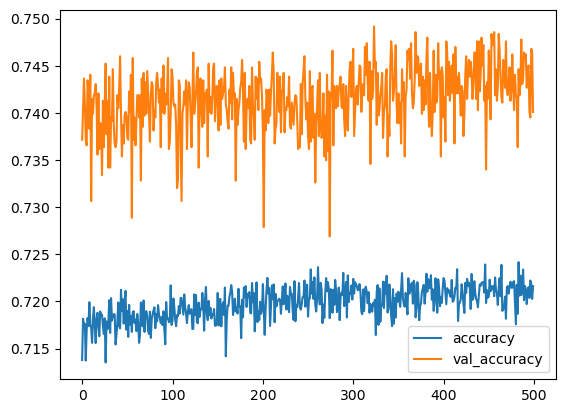

In [40]:
history_pd[['accuracy', 'val_accuracy']].plot.line();

In [41]:
y_val_pred = model.predict({'words_and_lemmas': X_val,
    'num_syllables': num_syllables_val})

397/397 [==============================] - 1s 3ms/step


In [42]:
accuracy_score(y_val, y_val_pred.argmax(axis=1))

0.7483448928121059

Проверка на разумность: номер предсказанного ударного слога не должен быть больше числа слогов в слове.

In [43]:
(y_val_pred.argmax(axis=1) > num_syllables_val).sum()

0

# Прогноз на тестовой выборке 

## Подготовка данных 

In [44]:
test = pd.read_csv('test.csv', index_col='id'); test

,word,num_syllables,lemma
id,,,
0,эпилепсия,5,эпилепсия
1,относящейся,5,относиться
2,размышлениями,6,размышление
3,модемы,3,модем
4,солнц,1,солнце
...,...,...,...
29955,донбасса,3,донбасс
29956,обложка,3,обложка
29957,правителя,4,правитель


Число символов и слова отдельно, т.к. подаю на разные входы нейронной сети

In [46]:
num_syllables_test = test.num_syllables
X_test = test.drop(columns=['num_syllables'])

Разделяем на буквы

In [47]:
word_test = X_test.word.apply(lambda x: ' '.join(list(x)))
lemma_test = X_test.lemma.apply(lambda x: ' '.join(list(x)))

In [48]:
word_test = word_test.str.split(expand=True); word_test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
id,,,,,,,,,,,,,,,,,,,
0,э,п,и,л,е,п,с,и,я,None,None,None,None,None,None,None,None,None,None
1,о,т,н,о,с,я,щ,е,й,с,я,None,None,None,None,None,None,None,None
2,р,а,з,м,ы,ш,л,е,н,и,я,м,и,None,None,None,None,None,None
3,м,о,д,е,м,ы,None,None,None,None,None,None,None,None,None,None,None,None,None
4,с,о,л,н,ц,None,None,None,None,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29955,д,о,н,б,а,с,с,а,None,None,None,None,None,None,None,None,None,None,None
29956,о,б,л,о,ж,к,а,None,None,None,None,None,None,None,None,None,None,None,None
29957,п,р,а,в,и,т,е,л,я,None,None,None,None,None,None,None,None,None,None


In [49]:
lemma_test = lemma_test.str.split(expand=True); lemma_test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
id,,,,,,,,,,,,,,,,,,,
0,э,п,и,л,е,п,с,и,я,None,None,None,None,None,None,None,None,None,None
1,о,т,н,о,с,и,т,ь,с,я,None,None,None,None,None,None,None,None,None
2,р,а,з,м,ы,ш,л,е,н,и,е,None,None,None,None,None,None,None,None
3,м,о,д,е,м,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,с,о,л,н,ц,е,None,None,None,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29955,д,о,н,б,а,с,с,None,None,None,None,None,None,None,None,None,None,None,None
29956,о,б,л,о,ж,к,а,None,None,None,None,None,None,None,None,None,None,None,None
29957,п,р,а,в,и,т,е,л,ь,None,None,None,None,None,None,None,None,None,None


Отсутсвующая буква в конце слова - 0. (Альтернативный вариант - ragged tensors.)

In [50]:
word_test.fillna(0, inplace=True)
lemma_test.fillna(0, inplace=True)

Заменяю буквы на номера

In [51]:
word_test = word_test.applymap(lambda x: alphabeth[x])
lemma_test = lemma_test.applymap(lambda x: alphabeth[x])

In [52]:
lemma_test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
id,,,,,,,,,,,,,,,,,,,
0,17,21,20,10,32,21,4,20,8,0,0,0,0,0,0,0,0,0,0
1,28,15,30,28,4,20,15,24,4,8,0,0,0,0,0,0,0,0,0
2,13,31,6,11,22,9,10,32,30,20,32,0,0,0,0,0,0,0,0
3,11,28,16,32,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,28,10,30,26,32,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29955,16,28,30,33,31,4,4,0,0,0,0,0,0,0,0,0,0,0,0
29956,28,33,10,28,18,12,31,0,0,0,0,0,0,0,0,0,0,0,0
29957,21,13,31,1,20,15,32,10,24,0,0,0,0,0,0,0,0,0,0


Объединяю

In [53]:
X_test = np.concatenate((word_test, lemma_test), axis=1); X_test

array([[17, 21, 20, ...,  0,  0,  0],
       [28, 15, 30, ...,  0,  0,  0],
       [13, 31,  6, ...,  0,  0,  0],
       ...,
       [21, 13, 31, ...,  0,  0,  0],
       [ 9, 32, 13, ...,  0,  0,  0],
       [28, 21, 15, ...,  0,  0,  0]])

## Прогноз 

In [54]:
y_test_pred = model.predict({'words_and_lemmas': X_test,
    'num_syllables': num_syllables_test})

937/937 [==============================] - 4s 3ms/step


In [56]:
y_test_pred = y_test_pred.argmax(axis=1)

In [ ]:
(y_test_pred > num_syllables_test).sum()

In [61]:
submission = pd.DataFrame(data=y_test_pred, index=test.index, columns=['stress'])
submission.stress = submission.stress + 1
submission

,stress
id,
0,3
1,3
2,3
3,2
4,1
...,...
29955,2
29956,2
29957,2


In [62]:
submission.to_csv('submission_01.csv')